# Import Packages

In [5]:
# built-in
from itertools import combinations
import os

# third-party (pip install required)
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pymodulon.io import load_json_model
from pymodulon.plotting import cluster_activities, plot_dima
from pymodulon.util import FDR
from scipy import stats
import seaborn as sns
from sklearn.metrics import r2_score
from tqdm.notebook import tqdm

# set matplotlib params
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.color'] = 'black'
matplotlib.rcParams['axes.labelcolor'] = 'black'
matplotlib.rcParams['xtick.color'] = 'black'
matplotlib.rcParams['ytick.color'] = 'black'
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

# Load Data

In [6]:
P1K_PATH = '../../data/precise1k/'
DEG_PATH = os.path.join(P1K_PATH, 'deg/')
ANNOTATION_PATH = '../../data/annotation/'
FIG_PATH = 'investigate_activities_figs/'

In [19]:
p1k = load_json_model(os.path.join(P1K_PATH, 'precise1k.json.gz'))

# Control Comparison

## Activities

In [4]:
control_metadata = p1k.sample_table[p1k.sample_table['condition'].isin(['wt_glc', 'wt_glc2'])]
control_ids = control_metadata.index

A_ctrl = p1k.A[control_ids]
A_ctrl_mad = A_ctrl.apply(stats.median_absolute_deviation, axis=1).sort_values(ascending=False)
A_ctrl_long = p1k.A[control_ids].stack().reset_index().rename(columns={'level_0': 'iM', 'level_1': 'id', 0: 'iM_activity'})
def id_to_proj(p1k_id):
    return control_metadata.loc[p1k_id, 'project']
A_ctrl_long = A_ctrl_long.assign(project=A_ctrl_long['id'].apply(id_to_proj))

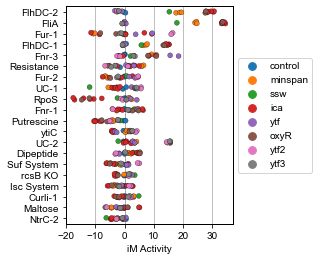

In [7]:
n_to_plot = 20

top_ims_in_order = A_ctrl_mad.index[:n_to_plot]
to_plot = A_ctrl_long[A_ctrl_long['iM'].isin(top_ims_in_order)]

_, ax = plt.subplots(figsize=(3, 4))

sns.stripplot(y='iM', x='iM_activity', data=to_plot, order=top_ims_in_order, hue='project', ax=ax, edgecolor='k', linewidth=0.25)
ax.legend(bbox_to_anchor=(1, 0.5), loc='center left')
ax.set_ylabel('')
ax.set_xlabel('iM Activity', fontsize=10)
ax.set_xticks(np.arange(-20, 40, 10))
ax.axvline(0, linestyle='--', linewidth=0.5, color='gray')
ax.xaxis.grid(True)
for s in ax.spines.values():
    s.set_color('k')
    s.set_linewidth(1)
    
plt.savefig(os.path.join(FIG_PATH, 'ctrl_activities.svg'), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join(FIG_PATH, 'ctrl_activities.png'), dpi=400, bbox_inches='tight')

## MADs

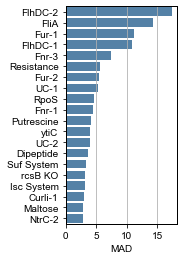

In [6]:
n_to_plot = 20
to_plot = A_ctrl_mad.iloc[:n_to_plot]
x_to_plot, y_to_plot = zip(*dict(to_plot).items())
to_plot_df = pd.DataFrame({'iM': x_to_plot, 'MAD': y_to_plot})

_, ax = plt.subplots(figsize=(2, 4))

sns.barplot(x='MAD', y='iM', orient='h', data=to_plot_df, color='steelblue', ax=ax)
ax.set_ylabel('')
ax.set_xlabel('MAD', fontsize=10)
ax.axvline(0, linestyle='--', linewidth=0.5, color='gray')
ax.set_xticks(np.arange(0, 20, 5))
ax.xaxis.grid(True)
for s in ax.spines.values():
    s.set_color('k')
    s.set_linewidth(1)
    
plt.savefig(os.path.join(FIG_PATH, 'ctrl_mads.svg'), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join(FIG_PATH, 'ctrl_mads.png'), dpi=400, bbox_inches='tight')

# DIMA

For quicker execution use customized, streamlined version of pymodulon code

## Function: dima_fast

In [7]:
diff_dict = {}

for name, group in p1k.sample_table.groupby(["project", "condition"]):
    for i1, i2 in combinations(group.index, 2):
        diff_dict[":".join(name)] = abs(p1k.A[i1] - p1k.A[i2])

diff_df = pd.DataFrame(diff_dict)
dist_dict = {}
for k in p1k.A.index:
    dist_dict[k] = stats.lognorm(*stats.lognorm.fit(diff_df.loc[k].values)).cdf

In [8]:
def dima_fast(full_name1, full_name2, fdr=0.05, threshold=5):

    p1k_ids1 = p1k.sample_table[p1k.sample_table['full_name'] == full_name1].index
    p1k_ids2 = p1k.sample_table[p1k.sample_table['full_name'] == full_name2].index

    def pval(row):
        return 1 - dist_dict[row.name](abs(row['difference']))
    result_df = pd.DataFrame().assign(
        difference=(p1k.A[p1k_ids2].mean(axis=1) - p1k.A[p1k_ids1].mean(axis=1))
    )

    result_df = result_df.assign(
        pvalue=result_df.apply(pval, axis=1)
    )

    result_sig = FDR(result_df, fdr)
    return result_sig[(abs(result_sig.difference) > threshold)].sort_values(
        "difference", ascending=False
    )

## DIMA Histogram

In [10]:
cond_pair_to_dima_count = {}
cond_pair_to_deg_count = {}
for deg_file in tqdm(os.listdir(DEG_PATH)):
    # ensure we're dealing with a CSV
    if '.csv' in deg_file:
        full_name_1, full_name_2 = [cond.replace('__', ':') for cond in deg_file.split('.')[0].split('_vs_')]
        dima_res = dima_fast(full_name_1, full_name_2, fdr=0.1, threshold=3)
        cond_pair_to_dima_count[(full_name_1, full_name_2)] = dima_res.shape[0]
        
        # re-hash the DEG analysis so we can do DEG vs DIMA
        deg_df = pd.read_csv(os.path.join(DEG_PATH, deg_file), index_col=0)
        # only accept adjusted p-values below 0.01 and larger log-fold changes
        sig_deg_df = deg_df[(deg_df['padj'] < 0.01) & (deg_df['log2FoldChange'].abs() > 1.5)]
        cond_pair_to_deg_count[(full_name_1, full_name_2)] = sig_deg_df.shape[0]

  0%|          | 0/6104 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


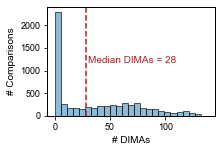

In [11]:
_, ax = plt.subplots(figsize=(3, 2))

sns.histplot(cond_pair_to_dima_count.values(), color='steelblue', bins=25, ax=ax)

ax.legend().set_visible(False)
ax.tick_params(axis='both', labelsize=9)
ax.set_xlabel('# DIMAs', fontsize=10)
ax.set_ylabel('# Comparisons')

median_dimas = np.median(list(cond_pair_to_dima_count.values()))
ax.axvline(median_dimas, linestyle='--', color='firebrick')
ax.text(median_dimas + 2.5, 1160, f'Median DIMAs = {median_dimas:.0f}', color='firebrick', fontsize=10)

for s in ax.spines.values():
    s.set_color('black')
    s.set_linewidth(1)
    
plt.savefig(os.path.join(FIG_PATH, 'dimas_histogram.svg'), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join(FIG_PATH, 'dimas_histogram.png'), dpi=400, bbox_inches='tight')

## DIMA vs DEG

8.692846152919808 DEGs per DIMA with linear fit


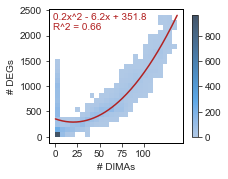

In [12]:
sns.set_style('ticks')

_, ax = plt.subplots(figsize=(3, 3))

x_vals = list(cond_pair_to_dima_count.values())
y_vals = list(cond_pair_to_deg_count.values())

bestfit = np.poly1d(np.polyfit(x_vals, y_vals, 1))
print(f'{bestfit.coefficients[0]} DEGs per DIMA with linear fit')

sns.histplot(x=x_vals, y=y_vals,cbar=True,bins=25,
             ax=ax, color='steelblue', cbar_kws={'shrink': 0.75})

ax.set_xticks(np.arange(0, 110, 25))
ax.set_xlabel('# DIMAs', fontsize=10)
ax.set_ylabel('# DEGs', fontsize=10)
ax.set_aspect(1./ax.get_data_ratio())

bestfit = np.poly1d(np.polyfit(x_vals, y_vals, 2))
r_squared = r2_score(y_vals, bestfit(x_vals))
ax.plot(np.unique(x_vals), bestfit(np.unique(x_vals)), color='firebrick')
ax.text(0.025, 0.9,
        f'{bestfit.coefficients[0]:.1f}x^2 - {abs(bestfit.coefficients[1]):.1f}x + {bestfit.coefficients[2]:.1f}\nR^2 = {abs(r_squared):.2f}',
        transform=ax.transAxes,color='firebrick',va='center')

for s in ax.spines.values():
    s.set_color('black')
    s.set_linewidth(1)
    
plt.savefig(os.path.join(FIG_PATH, 'dima_v_deg.svg'), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join(FIG_PATH, 'dima_v_deg.png'), dpi=400, bbox_inches='tight')

## Example DIMA

/Users/cam/.virtualenvs/ica/lib/python3.10/site-packages/pymodulon/util.py:174: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  _diff[":".join(name)] = abs(A_to_use[i1] - A_to_use[i2])
/Users/cam/.virtualenvs/ica/lib/python3.10/site-packages/pymodulon/util.py:174: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  _diff[":".join(name)] = abs(A_to_use[i1] - A_to_use[i2])
/Users/cam/.virtualenvs/ica/lib/python3.10/site-packages/pymodulon/util.py:174: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calli

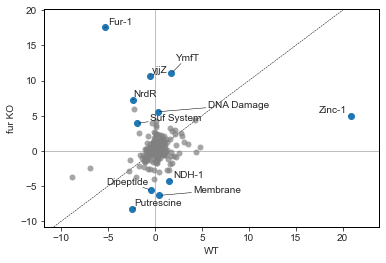

In [13]:
ax = plot_dima(p1k, 'fur:wt_fe', 'fur:delfur_fe2')

ax.set_xlabel('WT', fontsize=10)
ax.set_ylabel('fur KO', fontsize=10)
for s in ax.spines.values():
    s.set_color('k')
    s.set_linewidth(1)
    
plt.savefig(os.path.join(FIG_PATH, 'dima_example.svg'), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join(FIG_PATH, 'dima_example.png'), dpi=400, bbox_inches='tight')

# Activity Clusters

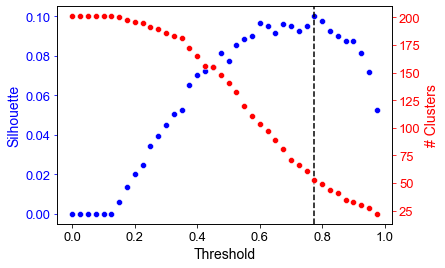

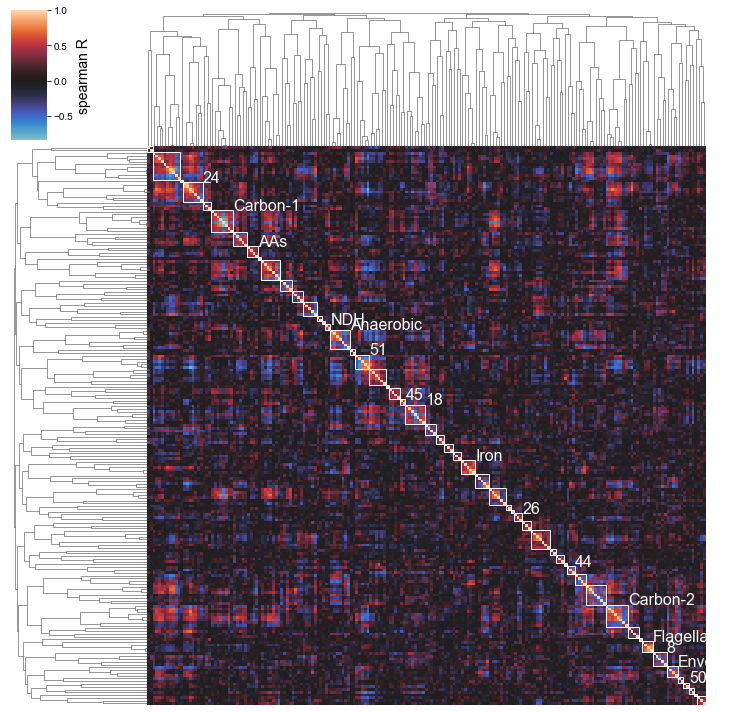

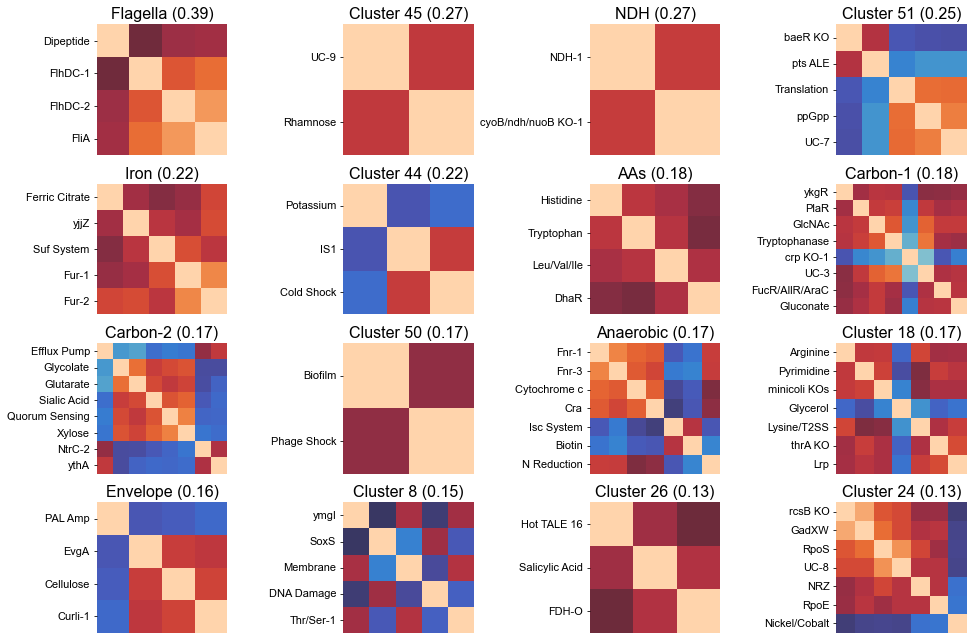

In [20]:
cluster_obj, clustermap = cluster_activities(p1k,
    show_thresholding=True, show_best_clusters=True, n_best_clusters=16, return_clustermap=True,
    cluster_names={32: 'Flagella', 49: 'NDH', 36: 'AAs', 25: 'Carbon-1', 41: 'Carbon-2', 22: 'Iron', 46: 'Envelope', 30: 'Anaerobic'}
)

# Transcriptome Allocation

## Define Treemap Definition for Use with Proteomaps

This section creates an iModulon-based treemap definition that can be used on: https://bionic-vis.biologie.uni-greifswald.de/usertreemapissues.php

In [18]:
p1k.gene_table.columns

Index(['gene_name', 'synonyms', 'gene_product', 'COG', 'regulator', 'uniprot',
       'start', 'end', 'strand', 'essential', 'core_genome', 'iML1515',
       'oxidizeME', 'DGF_strain', 'MS57', 'pseudogene', 'y_ome', 'k_eff',
       'schmidt_prot_med', 'heckmann_prot_med', 'proteomics', 'p1k',
       'p1k_ctrl_log_tpm', 'p1k_median_log_tpm', 'p1k_mad_log_tpm', 'in_iM'],
      dtype='object')

In [13]:
log_tpm_all = pd.read_csv('../../data/precise1k/log_tpm_qc_w_short_low_fpkm.csv', index_col=0)
for_tree = log_tpm_all.iloc[:, :2].mean(axis=1)
for_tree = for_tree.reset_index()
for_tree.to_csv('/Users/cam/Downloads/tree_test.tsv', header=False, sep='\t', index=False)

# Crp Binding

## Activity Tradeoff

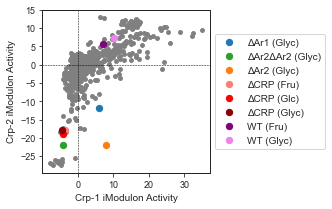

In [15]:
_, ax = plt.subplots(figsize=(3, 3))

color_dict = {
    'wt_fru': 'purple',
    'wt_glyc': 'violet',
    'delar1_glyc': 'tab:blue',
    'delar1ar2_glyc': 'tab:green',
    'delar2_glyc': 'tab:orange',
    'delcrp_fru': 'salmon',
    'delcrp_glc': 'red',
    'delcrp_glyc': 'darkred'
}

label_dict = {
    'wt_fru': 'WT (Fru)',
    'wt_glyc': 'WT (Glyc)',
    'delar1_glyc': 'ΔAr1 (Glyc)',
    'delar1ar2_glyc': 'ΔAr2ΔAr2 (Glyc)',
    'delar2_glyc': 'ΔAr2 (Glyc)',
    'delcrp_fru': 'ΔCRP (Fru)',
    'delcrp_glc': 'ΔCRP (Glc)',
    'delcrp_glyc': 'ΔCRP (Glyc)'
}

for (proj, cond), proj_cond_df in p1k.sample_table.groupby(['project', 'condition']):
    proj_cond_idx = proj_cond_df.index
    proj_cond_act = p1k.A[proj_cond_idx].mean(axis=1)
    crp1_act, crp2_act = proj_cond_act['Crp-1'], proj_cond_act['Crp-2']
    if proj == 'crp':
        ax.scatter(crp1_act, crp2_act, s=40, c=color_dict[cond], label=label_dict[cond], zorder=10)
    else:
        ax.scatter(crp1_act, crp2_act, s=15, c='gray')

ax.tick_params(axis='both', labelsize=9)
ax.axvline(0, color='black', linestyle='--', linewidth=0.5)
ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
ax.set_xlabel('Crp-1 iModulon Activity', fontsize=10)
ax.set_ylabel('Crp-2 iModulon Activity', fontsize=10)
ax.legend(fontsize=10, loc='center left', bbox_to_anchor=(1, 0.5))
for s in ax.spines.values():
    s.set_linewidth(1)
    
plt.savefig(os.path.join(FIG_PATH, 'crp_tradeoff.svg'), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join(FIG_PATH, 'crp_tradeoff.png'), dpi=400, bbox_inches='tight')

## Binding Site Locations

This plot was generated in the Strainware-s repository using the Bitome

## Binding Simulation

NameError: name 'kinetic_data' is not defined

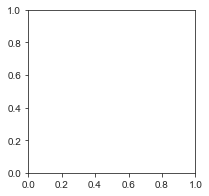

In [16]:
_, ax = plt.subplots(figsize=(3, 3))
sns.scatterplot(x='x', y='y', data=kinetic_data, s=10)
ax.tick_params(axis='both', labelsize=9)
ax.set_xlabel('Class I Fraction Bound', fontsize=10)
ax.set_ylabel('Class II Fraction Bound', fontsize=10)
for s in ax.spines.values():
    s.set_linewidth(1)
    
plt.savefig(os.path.join(FIG_PATH, 'crp_sim.svg'), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join(FIG_PATH, 'crp_sim.png'), dpi=400, bbox_inches='tight')